In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from snowflake.sqlalchemy import URL
pd.set_option('display.max_columns', None)

/Users/keyurpethad/anaconda3/lib/python3.11/site-packages/snowflake/connector/options.py:103: UserWarning: You have an incompatible version of 'pyarrow' installed (11.0.0), please install a version that adheres to: 'pyarrow<10.1.0,>=10.0.1; extra == "pandas"'
  warn_incompatible_dep(


In [2]:
from sqlalchemy import create_engine


class extractorFromQuery:
    def __init__(self):
        self.credentials = {
            "account": "qfi-niro",
            "user": "keyur",
            "password": "Keyur@17061996",
            "warehouse": "NIRO_ANALYTICS_WAREHOUSE",
        }

    def queryExecutor(self, query: str, *args):
        engine = create_engine(URL(**self.credentials))
        res = pd.read_sql_query(query, engine, params=args)
        return res

In [3]:
Q = """
        select * from (select
        distinct id.crn,
        id.los_app_id,
        id.gender,
        id.age,
        id.pincode,
        o.phone_number as "Phone_Number",
        p.pan_no as "Pan_Number",
        o.category,
        o.riskband2,
        o.max_amount, 
        o.interest_rate_perc,
        o.propensity,
        o.naps_score,
        o.dec_reason,
        la.loan_application_status,
        CASE when la.loan_disbursed_date_by_ops is null then date(la.disbursement_date)
            else date(la.loan_disbursed_date_by_ops)
        end as disbursement_date,
        rank() over(partition by o.user_id order by o.created_at desc) as rnk
        from 
        ANALYTICS.CRIF_FILES.idfc_demog as id 
        left join analytics.offers.offer_details o on id.crn = o.hashed_phone
        left join niro_rds.niro_data.core__public__loan_application la on la.user_id = o.user_id
        left join analytics.offers.personal_info as p on o.pii_id=p.pii_id
        left join analytics.offers.tradeline_info tli on o.tli_id = tli.tli_id
        where o.dec_reason = 'NOT DECLINED' 
        and o.platform_partner = 'Snapdeal' 
        and (p.pan_no is not null and pan_no<>'nan') 
        and o.created_at between '2023-01-01' and '2023-10-27'
        )
where rnk = 1;
"""

idfc_offers = (
    extractorFromQuery()
    .queryExecutor(Q)
)

idfc_offers.shape

(5120822, 18)

#### Creating Aggregate CRIF tradeline data

In [4]:
Q = """select los_app_id, count(los_app_id) as no_tr_l6m from(select los_app_id
from analytics.crif_files.account
where disbursed_dt >= '2023-04-27'
)
group by los_app_id"""

no_tr_l6m = (
    extractorFromQuery()
    .queryExecutor(Q)
)
no_tr_l6m.shape

(2544582, 2)

In [5]:
Q = """select los_app_id, max(credit_card_util) as max_cc_util from(select los_app_id, 
CASE when (credit_limit > 0) then (current_bal/credit_limit) 
when (disbursed_amt > 0) then (current_bal/disbursed_amt)
else null end as credit_card_util
from analytics.crif_files.account
where acct_type in ('Secured Credit Card', 'Credit Card', 'Kisan Credit Card', 'Loan on Credit Card', 'Loan against Card', 'Corporate Credit Card', 'Fleet Card')
)
group by los_app_id"""

max_cc_util = (
    extractorFromQuery()
    .queryExecutor(Q)
)
max_cc_util.shape

(4551533, 2)

In [6]:
max_cc_util.head(2)

,los_app_id,max_cc_util
0,GYBPS3059A,0.000000
1,FWSPM0771F,0.893987


In [7]:
Q = """select distinct crn, score as crif_score
from analytics.crif_files.idfc_output
where dec_reason = 'NOT DECLINED'"""

crif_score = (
    extractorFromQuery()
    .queryExecutor(Q)
)
crif_score.shape

(5088275, 2)

In [8]:
crif_score.loc[crif_score.crif_score.astype(float) < 650, 'crif_score'].value_counts(dropna=False).sum()

465807

In [9]:
Q = """select distinct crn,
1 as carded,
sector
from analytics.crif_files.idfc_output
where sector in ('Secured Credit Card', 'Credit Card', 'Kisan Credit Card', 'Loan on Credit Card', 'Loan against Card', 'Corporate Credit Card', 'Fleet Card')"""

carded = (
    extractorFromQuery()
    .queryExecutor(Q)
)
carded.head()

,crn,carded,sector
0,3f0869deb5471d87e68d08ec6e49a51644870a22edd357...,1,Credit Card
1,a31b8e7d586fd01585773f41a6a3c3056b62b4442c8816...,1,Credit Card
2,beea6e141a54c317bdc5a99ec963107f9ef661165d1413...,1,Credit Card
3,523549894bee556b5ffe3a458cfa67833348c7b58fd543...,1,Credit Card
4,dd09be5da90ccca8bb941470c2acb5b8c2b89ff4ae8224...,1,Credit Card


In [10]:
Q = """select crn,
max(ever_delq),
max(max_delq24),
max(max_delq12),
max(max_delq9),
max(max_delq6),
max(max_delq3),
min(credit_limit_santionedamount),
max(writeoff_status)
from analytics.crif_files.idfc_output
group by crn"""

perf = (
    extractorFromQuery()
    .queryExecutor(Q)
)
perf.head()

,crn,MAX(EVER_DELQ),MAX(MAX_DELQ24),MAX(MAX_DELQ12),MAX(MAX_DELQ9),MAX(MAX_DELQ6),MAX(MAX_DELQ3),MIN(CREDIT_LIMIT_SANTIONEDAMOUNT),MAX(WRITEOFF_STATUS)
0,e0aae95d26d508aa4c27c11aee787e5d30b96e31ebddc6...,0,0,0,0,0,0,NaN,0
1,063370145bd02b99c70c2944fa9be47729c88f97adbb38...,165,57,0,0,0,0,0.0,0
2,a38c9bc4ff8d2a1d267346707fc86ab6f890b56d0c45e7...,0,0,0,0,0,0,49000.0,0
3,8a6506bc6a4cfbd6663af46e9756f29cf85b8c10bc51fc...,0,0,0,0,0,0,30000.0,0
4,700c8d6781614f836e3ef9292f845abde9cf7c9eea7626...,0,0,0,0,0,0,NaN,0


#### Creating Aggregate CRIF Enquiry data

In [11]:
Q = """select crn, los_app_id, enquirydate
from analytics.crif_files.idfc_inq"""

idfc_inq = (
    extractorFromQuery()
    .queryExecutor(Q)
)
idfc_inq.shape

(6759908, 3)

In [12]:
idfc_inq.head()

,crn,los_app_id,enquirydate
0,df91521a9cd92180ed87de421fc92a2caeaa7d337fa7d4...,BOGPS2807N,None
1,aca91075d8471823343db9e3775f8ec0fed6b4bb48cef5...,BNJPM5605E,None
2,53f8603d0ac16fffa2943a0d6dcfda00eb6ccdcfe9413e...,BDTPM6007L,2022-08-02
3,2200c8e731f346643162544fe9cbec31a2438027f70853...,BOKPG3619C,2021-12-08
4,2200c8e731f346643162544fe9cbec31a2438027f70853...,BOKPG3619C,2022-03-15


In [13]:
idfc_inq.isna().sum()

crn                  0
los_app_id           0
enquirydate    3672472
dtype: int64

In [14]:
idfc_inq_df = idfc_inq.groupby(['crn'])['los_app_id'].count().reset_index().rename(columns = {'los_app_id':'enquiry_count_all'}).merge(
idfc_inq[idfc_inq.enquirydate.notna()].groupby(['crn'])['los_app_id'].count().reset_index().rename(columns = {'los_app_id':'enquiry_count_date_present'}), on = 'crn', how = 'left').merge(
idfc_inq[pd.to_datetime(idfc_inq['enquirydate']) >= pd.to_datetime('2023-05-01')].groupby(['crn'])['los_app_id'].count().reset_index().rename(columns = {'los_app_id':'enquiry_count_l6m'}), on = 'crn', how = 'left').merge(
idfc_inq[pd.to_datetime(idfc_inq['enquirydate']) >= pd.to_datetime('2023-08-01')].groupby(['crn'])['los_app_id'].count().reset_index().rename(columns = {'los_app_id':'enquiry_count_l3m'}), on = 'crn', how = 'left')
idfc_inq_df.head()


,crn,enquiry_count_all,enquiry_count_date_present,enquiry_count_l6m,enquiry_count_l3m
0,000000d18aa62311f6b4dfa6efd1e5b21ae32aa43e910c...,1,NaN,NaN,NaN
1,00000829e16edd2b5faea1943fe3cd334993383ed2eff0...,6,6.0,NaN,NaN
2,00000d66f992516ffa7cc547447ec0de596d3363049ca0...,3,3.0,1.0,NaN
3,00000e3f4049956668adc7fb95e41f8d081b39350abb86...,1,NaN,NaN,NaN
4,0000148e90dfd89aaa6dc126feb4dba636afa1fb1be3b5...,1,NaN,NaN,NaN


#### Approved base

In [15]:
Q = """select source_request_id as crn,
bureau_score,
exist_customer_flag,
loan_amount,
risk_segment,
roi,
yob,
1 as approved
from analytics.temp_test.idfc_whitelisted"""

idfc_approved = (
    extractorFromQuery()
    .queryExecutor(Q)
)
idfc_approved.shape

(172671, 8)

In [16]:
idfc_approved.head()

,crn,bureau_score,exist_customer_flag,loan_amount,risk_segment,roi,yob,approved
0,00d7bcbc50e0b281ca479ff7e469ba51f0b2122373c9a4...,844,0,500000,Low Risk,14.99,1979,1
1,02065948428f32b6b9685738576ccbb84d6395e71bf8b2...,681,0,500000,Medium Risk,20.99,1982,1
2,06d0ade2f5f216b2e2bd17237734d913cb9106d989dd1d...,842,0,500000,Low Risk,14.99,1967,1
3,08bdc62b40aef6b24c9bb449315313dc66c65e537cbffb...,758,0,80000,High Risk,19.49,1984,1
4,096d38b407683f9e15f31ce8cddddd5927ba5e755248f1...,776,0,75000,Low Risk,16.49,1985,1


In [17]:
idfc_base = pd.merge(idfc_offers, idfc_inq_df, on='crn', how='left') \
    .merge(idfc_approved, on='crn', how='left') \
    .merge(crif_score, on='crn', how='left') \
    .merge(perf, on='crn', how='left') \
    .merge(carded, on='crn', how='left') \
    .merge(no_tr_l6m, on='los_app_id', how='left') \
    .merge(max_cc_util, on='los_app_id', how='left')
idfc_base.shape

(5495947, 42)

Blocked pincodes

In [18]:
pincode_blocked = pd.read_excel('Pincode List_Blocking 09102023 IDFC.xlsx')
pincode_blocked.head()

,Pincodes
0,122015
1,110093
2,110083
3,121009
4,201310


In [19]:
idfc_base.loc[idfc_base.pincode.isin(pincode_blocked.Pincodes), 'loan_application_status'].value_counts()

loan_application_status
UNCLAIMED                        114236
PAN_VERIFICATION                   1422
MOBILE_VERIFICATION                1232
REJECTED                            393
LOAN_OFFER_ACCEPTANCE               310
ADDRESS_VERIFICATION                179
LOAN_EXECUTED                       175
LOAN_NACH_FLOW                       90
KYC                                  82
VERIFICATION                         80
BANKING_VERIFICATION                 54
CHECK_ELIGIBILITY                    12
AWAIT_RESPONSE                       11
EMPLOYMENT_DETAILS                   11
CLOSED                                9
LTFS_OFFER_PRESENTATION               9
CKYC                                  2
ELIGIBILITY_CHECK_IN_PROGRESS         2
SELFIE_VERIFICATION                   1
OFFER_PRESENTATION                    1
BANK_STATEMENT_UPLOAD                 1
REVISED_OFFER                         1
BRE                                   1
Name: count, dtype: int64

In [20]:
idfc_base.loc[idfc_base.pincode.isin(pincode_blocked.Pincodes), 'approved'].sum()

4272.0

In [21]:
idfc_base[['max_cc_util', 'no_tr_l6m']] = idfc_base[['max_cc_util', 'no_tr_l6m']].fillna(0)

Fixing CRIF issue

In [22]:
idfc_base['crif_score'] = idfc_base.crif_score.astype(float)
idfc_base = idfc_base[idfc_base.crif_score >= 650].reset_index(drop=True)

In [23]:
idfc_base.shape

(4990298, 42)

In [ ]:
idfc_base.drop_duplicates(subset = 'crn', inplace=True)
idfc_base.shape

## Analysis

### Figuring out hard rules

Carded

In [24]:
idfc_base.loc[idfc_base.approved.notna(), 'sector'].value_counts(dropna=False)

sector
Credit Card              149037
Kisan Credit Card         44952
Loan on Credit Card       10811
Corporate Credit Card      6746
Secured Credit Card         801
Fleet Card                   17
Loan against Card             2
Name: count, dtype: int64

In [26]:
idfc_base.carded.value_counts(dropna=False)

carded
1.0    3049197
NaN    1573271
Name: count, dtype: int64

CRIF score

In [ ]:
idfc_base.bureau_score.min(), idfc_base.bureau_score.max()

In [ ]:
plt.figure(figsize=(8, 6))
idfc_base.hist(column = 'bureau_score', bins=20)
plt.title(f'Histogram for bureau_score')
plt.xlabel('bureau_score')
plt.ylabel('Frequency')
plt.show()

In [ ]:
idfc_base.crif_score.min(), idfc_base.crif_score.max()

In [ ]:
plt.figure(figsize=(8, 6))
idfc_base.hist(column = 'crif_score', bins=20)
plt.title(f'Histogram for crif_score')
plt.xlabel('crif_score')
plt.ylabel('Frequency')
plt.show()

Year of birth

In [ ]:
idfc_base.yob.min(), idfc_base.yob.max()
# Max age - 60, min age - 20

In [ ]:
plt.figure(figsize=(8, 6))
idfc_base.hist(column = 'yob', bins=20)
plt.title(f'Histogram for yob')
plt.xlabel('yob')
plt.ylabel('Frequency')
plt.show()

Enquiry

In [ ]:
idfc_base['enquiry_count_all'].value_counts(dropna=False)

In [ ]:
idfc_base.loc[idfc_base.approved.notna(), 'enquiry_count_all'].value_counts(dropna=False)

In [ ]:
idfc_base['enquiry_count_date_present'].value_counts(dropna=False)

In [ ]:
idfc_base.loc[idfc_base.approved.notna(), 'enquiry_count_date_present'].value_counts(dropna=False)

In [ ]:
idfc_base['enquiry_count_l6m'].value_counts(dropna=False)

In [ ]:
idfc_base.loc[idfc_base.approved.notna(), 'enquiry_count_l6m'].value_counts(dropna=False)

In [ ]:
idfc_base['enquiry_count_l3m'].value_counts(dropna=False)

In [ ]:
idfc_base.loc[idfc_base.approved.notna(), 'enquiry_count_l3m'].value_counts(dropna=False)

max_cc_util

In [ ]:
idfc_base['max_cc_util'] = np.where((idfc_base['max_cc_util'] < 0) | (idfc_base['max_cc_util'] >= 1) | idfc_base['max_cc_util'].isna(), 0, idfc_base['max_cc_util'])

In [ ]:
idfc_base['max_cc_util'].min(), idfc_base['max_cc_util'].max()

In [ ]:
idfc_base.loc[idfc_base.approved.notna(), 'max_cc_util'].min(), idfc_base.loc[idfc_base.approved.notna(), 'max_cc_util'].max()

In [ ]:
import seaborn as sns
sns.kdeplot(idfc_base.loc[idfc_base.approved.notna()], x = 'max_cc_util')
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
idfc_base.hist(column = 'max_cc_util', bins=200)
plt.title(f'Histogram for max_cc_util')
plt.xlabel('max_cc_util')
plt.ylabel('Frequency')
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
idfc_base.loc[idfc_base.approved.notna()].hist(column = 'max_cc_util', bins=200)
plt.title(f'Histogram for max_cc_util')
plt.xlabel('max_cc_util')
plt.ylabel('Frequency')
plt.show()

In [ ]:
idfc_base.head(2)

MAX(EVER_DELQ)

In [ ]:
idfc_base['MAX(EVER_DELQ)'].min(), idfc_base['MAX(EVER_DELQ)'].max()

In [ ]:
idfc_base.loc[idfc_base.approved.notna(), 'MAX(EVER_DELQ)'].min(), idfc_base.loc[idfc_base.approved.notna(), 'MAX(EVER_DELQ)'].max()

In [ ]:
plt.figure(figsize=(8, 6))
idfc_base.hist(column = 'MAX(EVER_DELQ)', bins=20)
plt.title(f'Histogram for MAX(EVER_DELQ)')
plt.xlabel('MAX(EVER_DELQ)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
idfc_base.loc[idfc_base.approved.notna()].hist(column = 'MAX(EVER_DELQ)', bins=20)
plt.title(f'Histogram for MAX(EVER_DELQ)')
plt.xlabel('MAX(EVER_DELQ)')
plt.ylabel('Frequency')
plt.show()

MAX(MAX_DELQ3)

In [ ]:
idfc_base['MAX(MAX_DELQ3)'].min(), idfc_base['MAX(MAX_DELQ3)'].max()

In [ ]:
idfc_base.loc[idfc_base.approved.notna(), 'MAX(MAX_DELQ3)'].min(), idfc_base.loc[idfc_base.approved.notna(), 'MAX(MAX_DELQ3)'].max()

In [ ]:
plt.figure(figsize=(8, 6))
idfc_base.hist(column = 'MAX(MAX_DELQ3)', bins=10)
plt.title(f'Histogram for MAX(MAX_DELQ3)')
plt.xlabel('MAX(MAX_DELQ3)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
idfc_base.loc[idfc_base.approved.notna()].hist(column = 'MAX(MAX_DELQ3)', bins=10)
plt.title(f'Histogram for MAX(MAX_DELQ3)')
plt.xlabel('MAX(MAX_DELQ3)')
plt.ylabel('Frequency')
plt.show()

### Approved Analysis

#### Propensity

In [ ]:
idfc_base.propensity.value_counts(dropna=False)

In [ ]:
idfc_base[idfc_base.approved.notna()].propensity.value_counts(dropna=False)

In [ ]:
so_wc_screen = pd.read_excel('Welcome screen base.xlsx')
so_wc_screen.head()

In [ ]:
idfc_base.loc[idfc_base['Phone_Number'].isin(so_wc_screen['Phone number'].astype(str)), 'propensity'].value_counts(dropna=False, normalize=True)

#### Category

In [ ]:
idfc_base.category.value_counts(dropna=False)

In [ ]:
idfc_base[idfc_base.approved.notna()].category.value_counts(dropna=False)

#### NAPS

In [ ]:
def naps_score_bkt(row, var):
    if row[var] <= 675:
        return '<=675'
    elif row[var] <= 690:
        return '675-690'
    elif row[var] <= 715:
        return '690-715'
    elif row[var] <= 750:
        return '715-750'
    elif row[var] <= 790:
        return '750-790'
    else:
        return '790+'

In [ ]:
idfc_base['naps_band'] = idfc_base.apply(naps_score_bkt,var='naps_score',axis=1)

In [ ]:
idfc_base.naps_band.value_counts(dropna=False)

In [ ]:
idfc_base[idfc_base.approved.notna()].naps_band.value_counts(dropna=False)

#### Approved case analysis

In [ ]:
def loan_amount_bkt(row, var):
    if row[var] <= 80000:
        return '<=80K'
    elif row[var] <= 100000:
        return '80K-100K'
    elif row[var] <= 200000:
        return '100K-200K'
    elif row[var] <= 300000:
        return '200K-300K'
    else:
        return '300K+'

def roi_bkt(row, var):
    if row[var] <= 19:
        return '<=19'
    elif row[var] <= 21:
        return '19-21'
    elif row[var] <= 24:
        return '21-24'
    elif row[var] <= 26:
        return '24-26'
    elif row[var] <= 28:
        return '26-28'
    else:
        return '28+'

In [ ]:
idfc_base['idfc_la_bkt'] = idfc_base.apply(loan_amount_bkt,var='loan_amount',axis=1)
idfc_base['niro_la_bkt'] = idfc_base.apply(loan_amount_bkt,var='max_amount',axis=1)

In [ ]:
idfc_base['idfc_roi_bkt'] = idfc_base.apply(roi_bkt,var='roi',axis=1)
idfc_base['niro_roi_bkt'] = idfc_base.apply(roi_bkt,var='interest_rate_perc',axis=1)

#### Disbursed

In [ ]:
idfc_base[idfc_base.loan_application_status.isin(['CLOSED','LOAN_EXECUTED'])]

#### IDFC cleanest base

In [30]:
idfc_base['approved'] = np.where(idfc_base['approved'].isna(), "Not Approved", "Approved")

In [ ]:
clean_base = idfc_base[idfc_base['carded'].notna() & (idfc_base['MAX(EVER_DELQ)'] < 30) & (idfc_base['crif_score'] >= 700) & (idfc_base['enquiry_count_l6m'] <= 3) & (idfc_base['max_cc_util'] <= 0.65) & (idfc_base['no_tr_l6m'] <= 1)].reset_index(drop=True)

In [ ]:
idfc_base[~idfc_base.crn.isin(clean_base.crn) & idfc_base['carded'].notna()].shape

In [ ]:
clean_base.shape

In [ ]:
clean_base.approved.value_counts(dropna=False)

In [ ]:
clean_base.approved.value_counts(normalize = True, dropna=False)

In [ ]:
idfc_base[idfc_base['carded'].notna()].crif_score 

In [ ]:
idfc_base[~idfc_base.crn.isin(clean_base.crn) & idfc_base['carded'].notna()].approved.value_counts(normalize=True, dropna=False)

In [ ]:
# idfc_base[idfc_base.approved.notna()].reset_index(drop=True).to_csv('approved_base_idfc.csv')

In [ ]:
clean_base.to_excel('clean_base.xlsx')

#### Rejected base vs Approved base

In [27]:
idfc_base.head()

,crn,los_app_id,gender,age,pincode,Phone_Number,Pan_Number,category,riskband2,max_amount,interest_rate_perc,riskband2,propensity,naps_score,dec_reason,loan_application_status,disbursement_date,rnk,enquiry_count_all,enquiry_count_date_present,enquiry_count_l6m,enquiry_count_l3m,bureau_score,exist_customer_flag,loan_amount,risk_segment,roi,yob,approved,crif_score,MAX(EVER_DELQ),MAX(MAX_DELQ24),MAX(MAX_DELQ12),MAX(MAX_DELQ9),MAX(MAX_DELQ6),MAX(MAX_DELQ3),MIN(CREDIT_LIMIT_SANTIONEDAMOUNT),MAX(WRITEOFF_STATUS),carded,sector,no_tr_l6m,max_cc_util
0,403555483d66ff8ad345f58ccbd53cbbe1dd02a2713a15...,BGVPA3558F,MALE,31.0,800001,9585240929,BGVPA3558F,CAT-B,M,231000.0,21.9,M,HiiProp,782.0,NOT DECLINED,UNCLAIMED,None,1,2,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,762.0,0,0,0,0,0,0,15000.0,0,1.0,Credit Card,3.0,0.000000
1,76e2a34d0aef12d0ba40b277da61e5287f661613c20f17...,BEKPK7341P,MALE,35.0,412307,9765559420,BEKPK7341P,CAT-B,L,385000.0,19.9,L,LowProp,776.0,NOT DECLINED,UNCLAIMED,None,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,812.0,0,0,0,0,0,0,20000.0,0,1.0,Credit Card,0.0,0.085656
2,7103c6549e7291267d5e7275f30af64fdc351dc39ae7e0...,DGTPP7657E,FEMALE,31.0,390007,8618993365,DGTPP7657E,CAT-A,L,483000.0,18.9,L,LowProp,772.0,NOT DECLINED,UNCLAIMED,None,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,735.0,0,0,0,0,0,0,20000.0,0,1.0,Credit Card,2.0,0.010300
3,f4a7de462e759a3a6f7c392ed1c9464cecdd6a1777aa7b...,HFMPK5564P,MALE,25.0,145001,7814753543,HFMPK5564P,CAT-D,M,56000.0,28.9,M,MedProp,744.0,NOT DECLINED,UNCLAIMED,None,1,3,3.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,676.0,0,0,0,0,0,0,44000.0,0,1.0,Credit Card,2.0,0.000000
4,8a8f4cc82054d051170aba809a0492bb0fe95c42e937ed...,IFGPS8612B,MALE,32.0,492001,7828820602,IFGPS8612B,CAT-D,M,51000.0,27.9,M,MedProp,707.0,NOT DECLINED,UNCLAIMED,None,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,719.0,0,0,0,0,0,0,NaN,0,NaN,NaN,1.0,0.000000


In [28]:
idfc_base[idfc_base.approved.isin(['Approved'])].shape

(0, 42)

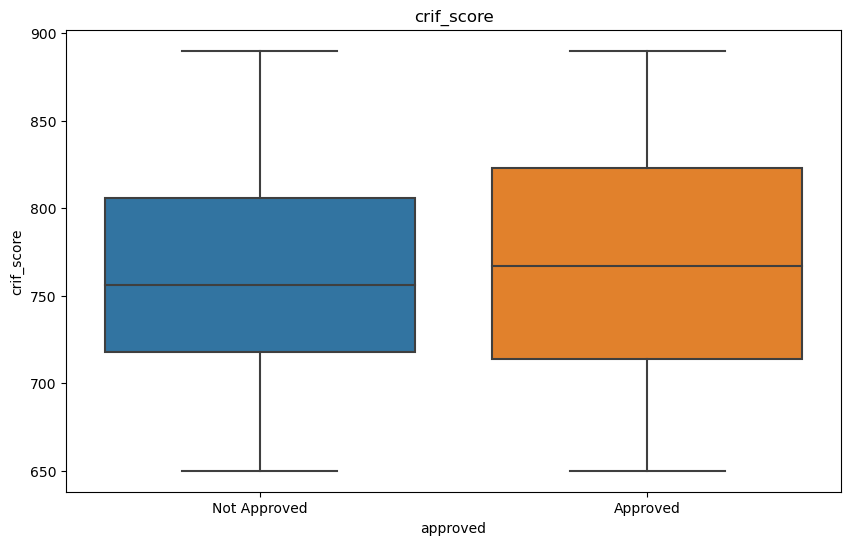

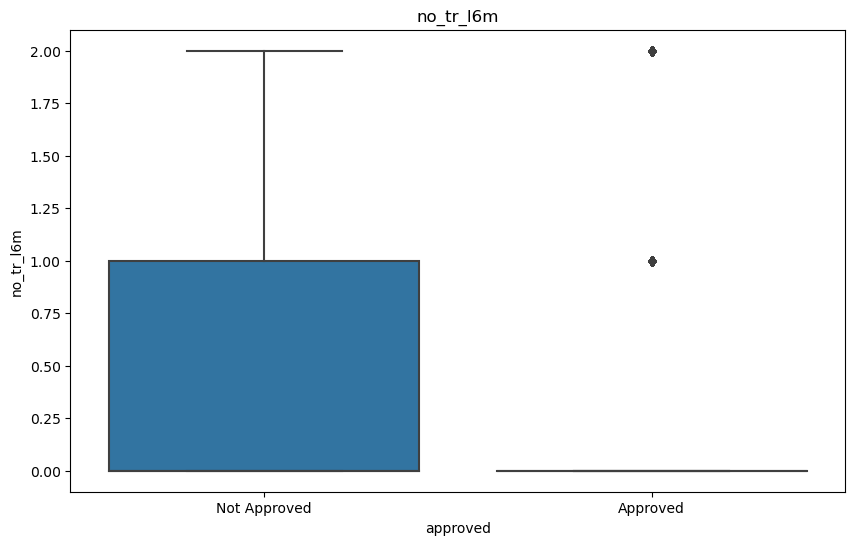

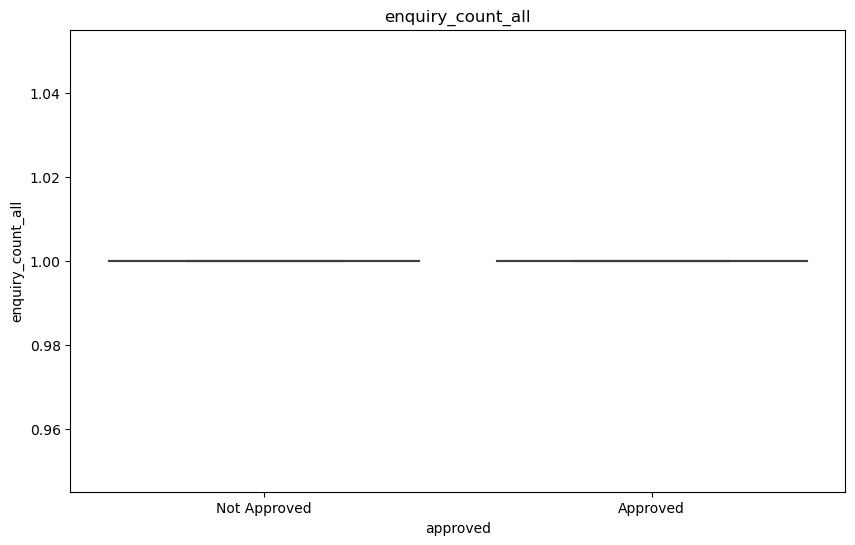

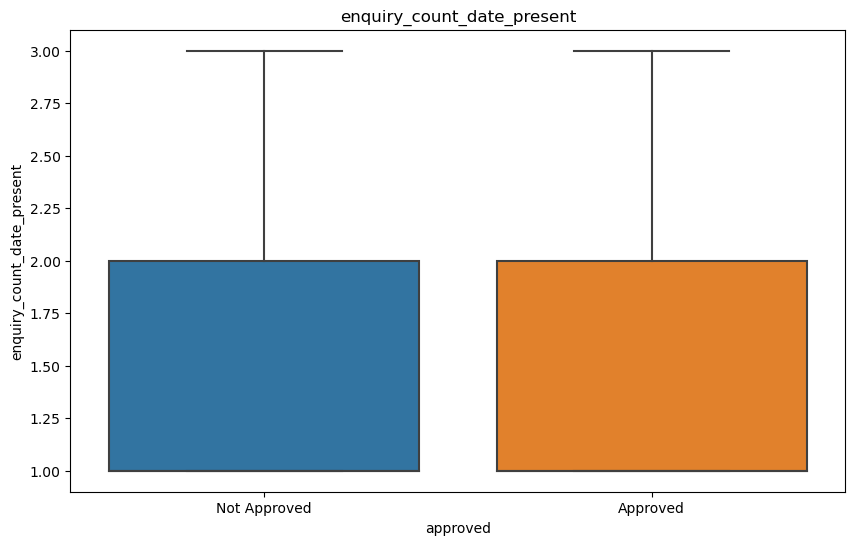

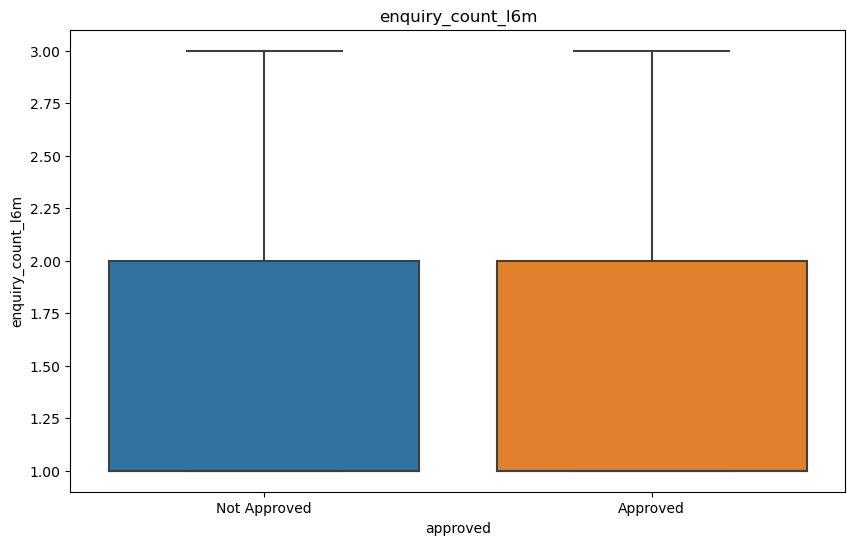

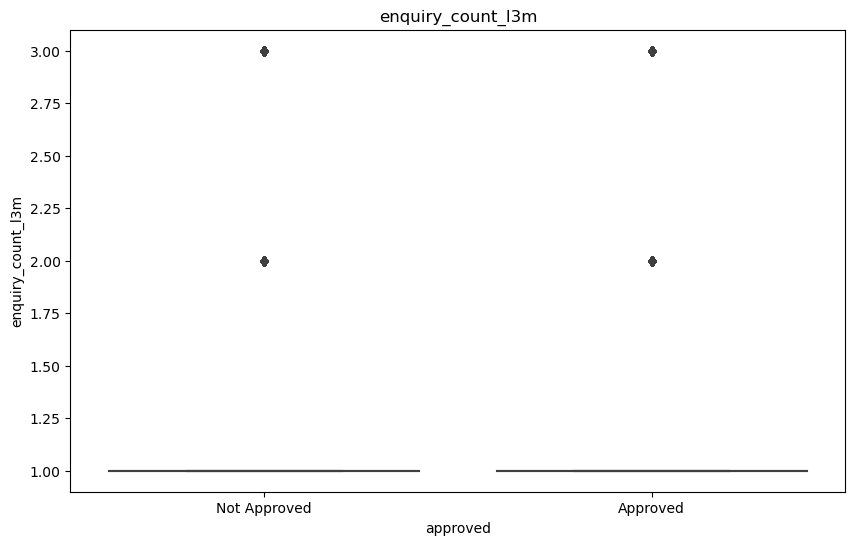

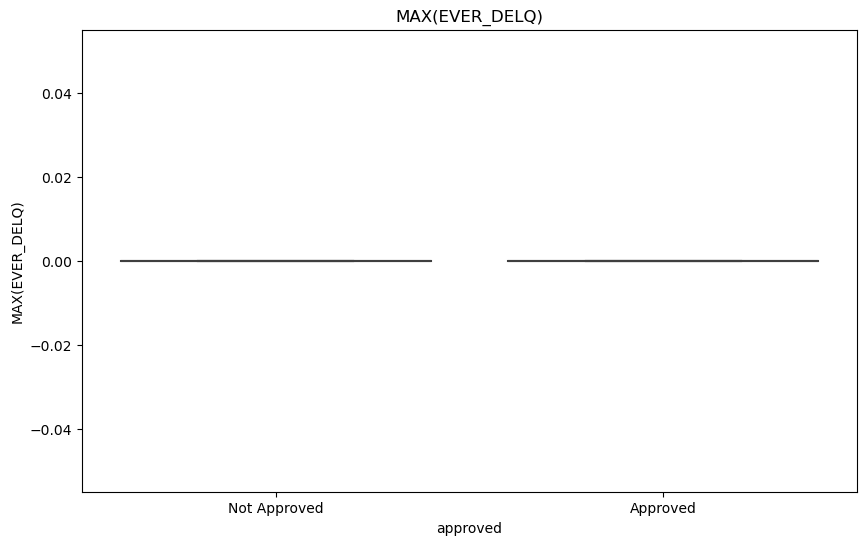

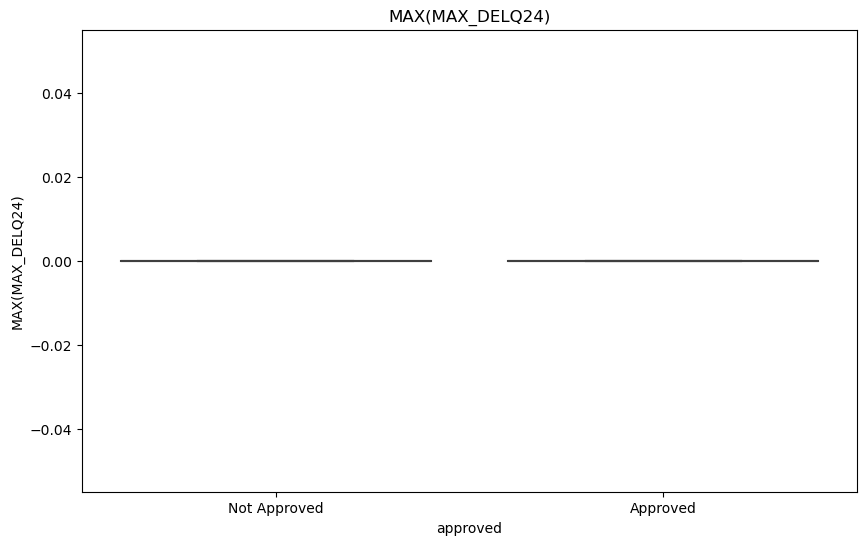

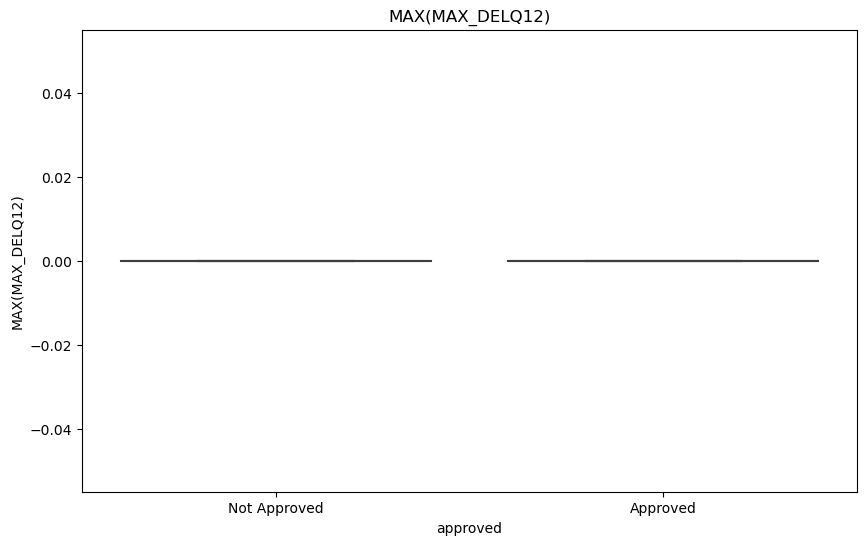

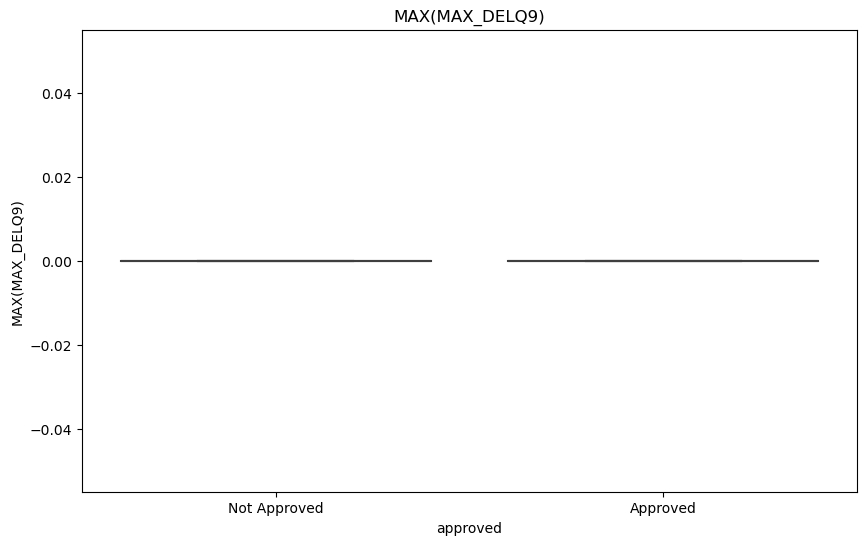

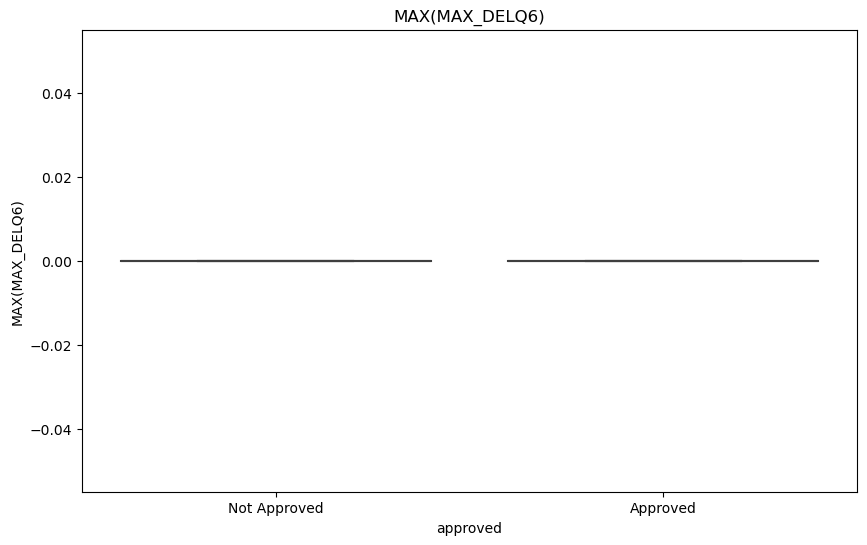

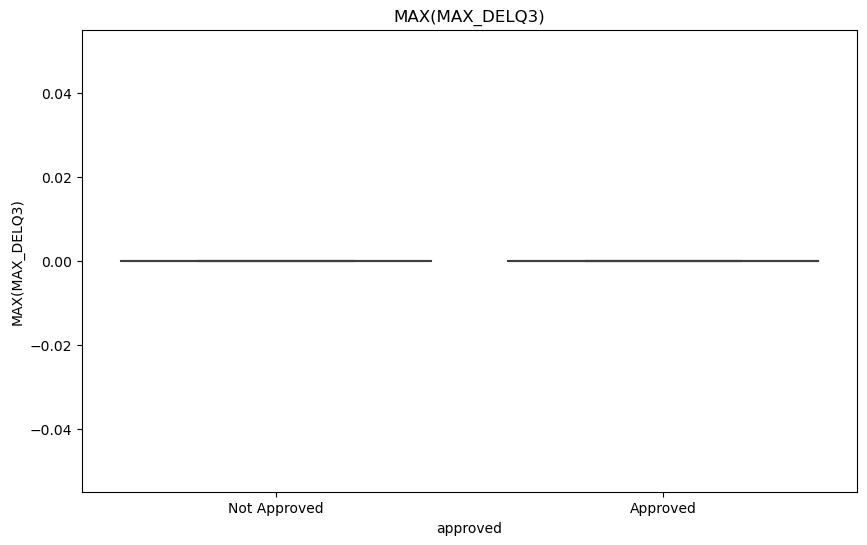

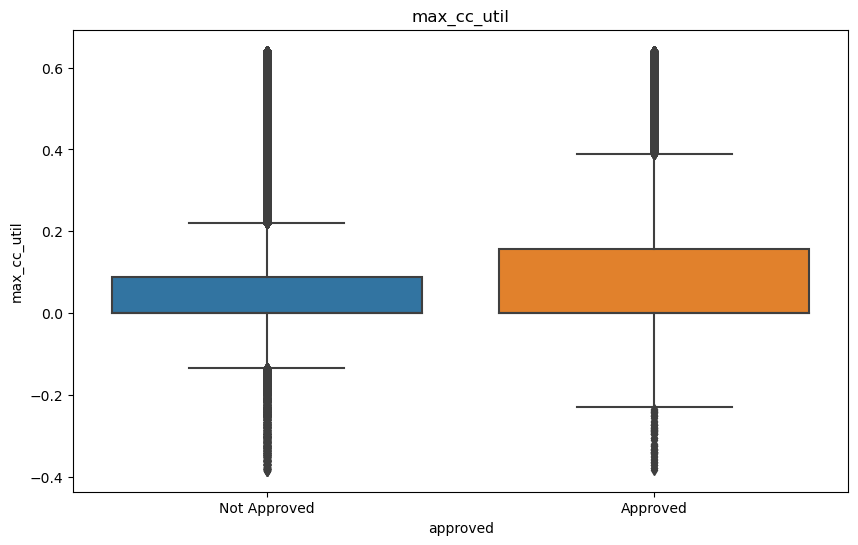

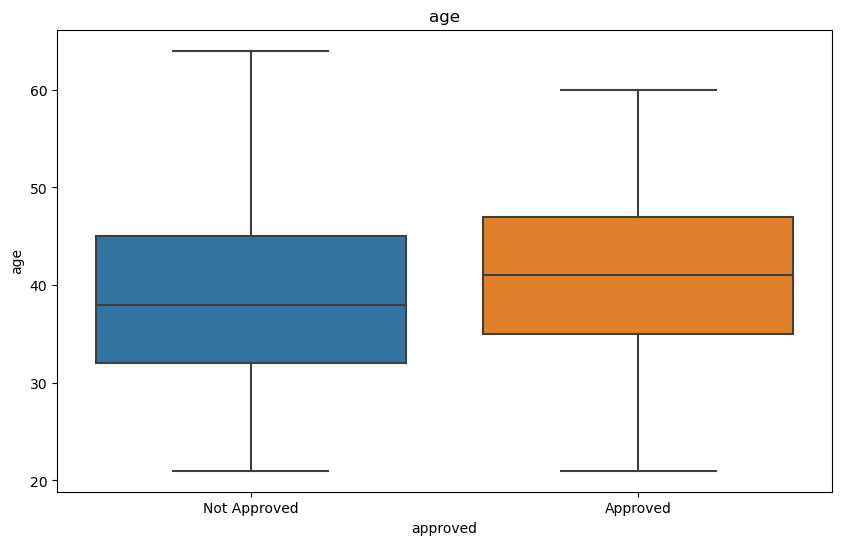

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define function to remove outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

fields = ["crif_score", "no_tr_l6m", "enquiry_count_all", "enquiry_count_date_present", "enquiry_count_l6m", "enquiry_count_l3m", "MAX(EVER_DELQ)", "MAX(MAX_DELQ24)", "MAX(MAX_DELQ12)", "MAX(MAX_DELQ9)", "MAX(MAX_DELQ6)", "MAX(MAX_DELQ3)", "max_cc_util", "age"]

for field in fields:
    idfc_base_no_outliers = remove_outliers(idfc_base, field)

    # Create box plot without outliers
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="approved", y=field, data=idfc_base_no_outliers)
    plt.title(field)
    plt.ylabel(field)
    plt.show()


In [35]:
idfc_base['crif_score_bkt'] = np.where(idfc_base['crif_score'] <= 700, 'A) 650 - 700',
                                np.where(idfc_base['crif_score'] <= 720, 'B) 700 - 720',
                                    np.where(idfc_base['crif_score'] <= 750, 'C) 720 - 750',
                                        np.where(idfc_base['crif_score'] <= 800, 'D) 750 - 800',
                                            np.where(idfc_base['crif_score'] > 800, 'E) 800+',None)))))

#### CRIF vs Risk segment crosstab

In [56]:
import pandas as pd

# Assuming 'approved' column contains 'Approved' or 'Not Approved'
# Replace 'Approved' with 1 and 'Not Approved' with 0
idfc_base['approved_binary'] = idfc_base['approved'].replace({'Approved': 1, 'Not Approved': 0})

# Create crosstab
cross_tab = pd.crosstab(index=idfc_base['crif_score_bkt'], 
                        columns=idfc_base['risk_segment'], 
                        values=idfc_base['approved_binary'], 
                        aggfunc='sum')

# Calculate total approvals for each crif_score_bkt
total_approvals = cross_tab.sum().sum()

# Calculate percentages
cross_tab_percentages = cross_tab.divide(total_approvals, axis=0) * 100

print(cross_tab_percentages)


risk_segment    High Risk   Low Risk  Medium Risk
crif_score_bkt                                   
A) 650 - 700     1.595548  10.707832     5.697639
B) 700 - 720     1.545741   6.444159     3.713485
C) 720 - 750     1.982996   7.080061     4.919267
D) 750 - 800     3.481826   9.998958     7.571756
E) 800+          6.544351  16.245048    12.471332


In [61]:
idfc_base.head()

,crn,los_app_id,gender,age,pincode,Phone_Number,Pan_Number,category,riskband2,max_amount,interest_rate_perc,riskband2,propensity,naps_score,dec_reason,loan_application_status,disbursement_date,rnk,enquiry_count_all,enquiry_count_date_present,enquiry_count_l6m,enquiry_count_l3m,bureau_score,exist_customer_flag,loan_amount,risk_segment,roi,yob,approved,crif_score,MAX(EVER_DELQ),MAX(MAX_DELQ24),MAX(MAX_DELQ12),MAX(MAX_DELQ9),MAX(MAX_DELQ6),MAX(MAX_DELQ3),MIN(CREDIT_LIMIT_SANTIONEDAMOUNT),MAX(WRITEOFF_STATUS),carded,sector,no_tr_l6m,max_cc_util,crif_score_bkt,approved_binary
0,403555483d66ff8ad345f58ccbd53cbbe1dd02a2713a15...,BGVPA3558F,MALE,31.0,800001,9585240929,BGVPA3558F,CAT-B,M,231000.0,21.9,M,HiiProp,782.0,NOT DECLINED,UNCLAIMED,None,1,2,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Approved,762.0,0,0,0,0,0,0,15000.0,0,1.0,Credit Card,3.0,0.000000,D) 750 - 800,0
1,76e2a34d0aef12d0ba40b277da61e5287f661613c20f17...,BEKPK7341P,MALE,35.0,412307,9765559420,BEKPK7341P,CAT-B,L,385000.0,19.9,L,LowProp,776.0,NOT DECLINED,UNCLAIMED,None,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Approved,812.0,0,0,0,0,0,0,20000.0,0,1.0,Credit Card,0.0,0.085656,E) 800+,0
2,7103c6549e7291267d5e7275f30af64fdc351dc39ae7e0...,DGTPP7657E,FEMALE,31.0,390007,8618993365,DGTPP7657E,CAT-A,L,483000.0,18.9,L,LowProp,772.0,NOT DECLINED,UNCLAIMED,None,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Approved,735.0,0,0,0,0,0,0,20000.0,0,1.0,Credit Card,2.0,0.010300,C) 720 - 750,0
3,f4a7de462e759a3a6f7c392ed1c9464cecdd6a1777aa7b...,HFMPK5564P,MALE,25.0,145001,7814753543,HFMPK5564P,CAT-D,M,56000.0,28.9,M,MedProp,744.0,NOT DECLINED,UNCLAIMED,None,1,3,3.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Not Approved,676.0,0,0,0,0,0,0,44000.0,0,1.0,Credit Card,2.0,0.000000,A) 650 - 700,0
4,8a8f4cc82054d051170aba809a0492bb0fe95c42e937ed...,IFGPS8612B,MALE,32.0,492001,7828820602,IFGPS8612B,CAT-D,M,51000.0,27.9,M,MedProp,707.0,NOT DECLINED,UNCLAIMED,None,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Approved,719.0,0,0,0,0,0,0,NaN,0,NaN,NaN,1.0,0.000000,B) 700 - 720,0


## CIBIL data

In [65]:
cibil_df_with_cvattrs = """
            select * from (
            select 
            distinct la.id,
            pii.gender as cibil_gender,
            pii.pin as cibil_pincode,
            pii.calculated_age,
            pii.city as cibil_city,
            pii.state as cibil_state,
            pii.native_language,
            tli.*,
            date_trunc("MONTH",date(od.created_at)) as createdate,
            rank()over(partition by od.user_id order by od.created_at asc) as rnk
            from NIRO_RDS.NIRO_DATA.CORE__PUBLIC__LOAN_APPLICATION la
            left join NIRO_RDS.NIRO_DATA.core__public__offer_user_details ou on ou.offer_id = la.offer_id
            left join ANALYTICS.OFFERS.offer_details od on od.user_id = la.user_id and od.category = ou.category
            left join ANALYTICS.OFFERS.personal_info pii on od.pii_id = pii.pii_id
            left join ANALYTICS.OFFERS.tradeline_info tli on tli.tli_id = od.tli_id
            where la.is_deleted = False
            and(la.is_deleted_at_source = false or la.is_deleted_at_source is null)
            )
where rnk = 1;
"""
cibil_df = (
    extractorFromQuery()
    .queryExecutor(cibil_df_with_cvattrs)
)
cibil_df.shape

In [ ]:
column_name_map = {'agg911': 'max_aggregate_bankcard_utilisation_l12m', 'rvlr01': 'cc_util_revolving_l1m', 'bcpmtstr': 'bank_card_payment_category', 'cv11': 'no_of_60p_accs_ever', 'cv14': 'no_of_deduped_inquiries', 
                   'mt28s': 'total_cl_open_mortgage_trades_l12m', 'mt33s': 'total_balance_open_mortgage_trades_l12m', 'pl33s':'total_bal_of_open_pl_l12m', 'at20s':'months_since_oldest_trade', 
                   'mt01s':'no_of_mortgage_trades', 'bc02s':'no_of_open_cc_trades', 'bg01s':'no_of_business_general_trades', 'cv10':'no_of_30p_accs_ever', 'trd':'no_of_trades', 'at33a':'total_bal_open_trades_l12m',
                   'au33s':'total_bal_open_auto_trades_l12m', 'co04s180':'months_since_recent_chargedoff180P', 'au28s':'total_cl_open_auto_trades_l12m', 'pl28s':'total_cl_open_pl_trades_l12m',
                   'co01s180':'no_of_chargedoff180P', 'bc28s':'total_cl_of_cc_trades_l12m', 'cv12':'no_of_90p_accs_ever', 'co05s':'total_bal_of_chargedoff_trades', 'g310s':'worst_rating_l12m',
                   'aggs911':'current_utilization_of_top_wallet_bankcard', 'at01s':'no_of_trades_pl_2w_gl_cd', 'at33a_ne_ccod':'total_bal_open_trades_l12m_except_wo_cc_od', 'cv14_12m':'no_of_deduped_inquiries_l12m',
                   'cv14_6m':'no_of_deduped_inquiries_l6m', 'cv14_3m':'no_of_deduped_inquiries_l3m', 'cv14_1m':'no_of_deduped_inquiries_l1m', 'g310s_24m':'worst_rating_l24m',
                   'g310s_6m':'worst_rating_l6m', 'g310s_3m':'worst_rating_l3m', 'g310s_1m':'worst_rating_l1m', 'cv11_24m':'no_of_60p_accs_l24m', 'cv11_12m':'no_of_60p_accs_l12m', 'g057s_1dpd_36m': 'no_of_trades_bounced_l36m',
                   'g057s_1dpd_12m':'no_of_trades_bounced_l12m', 'bc106s_60dpd':'no_of_cc_trades_60P_l24m', 'bc107s_24m':'no_of_30P_cc_l24m', 'bc106s_60dpd_12m':'no_of_cc_trades_60P_l12m', 'bc107s_12m':'no_of_30P_cc_l12m',
                   'bc106s_le_30dpd_12m':'no_of_cc_lt30p_l12m', 'bc09s_36m_hcsa_le_30':'no_cc_sanctionedamt_lt30K_l36m', 'pl09s_36m_hcsa_le_30':'no_pl_sanctionedamt_lt30K_l36m', 'at09s_6m':'no_tr_opened_l6m',
                   'g310s_36m':'worst_dpd_l36m', 'at33a_ne_wo':'total_bal_open_trades_l12m_minus_total_bal_of_chargedoff_trades', 'at09s_12m':'no_tr_opened_l12m', 'at09s_3m':'no_tr_opened_l3m', 'cv13':'per_of_30p_accs_ever',
                    'cv24':'total_payment_amount_bankcard_accs_l3m', 'revs904':'max_revolving_monthly_spend_l12m', 'cv20':'total_monthly_obligations_l3m', 'cv22':'total_balance_bankcard_accs_l3m', 
                    'ul_trd':'no_of_trades_unsec', 'cv21':'total_payment_amount_l3m', 'g310s_2m':'worst_dpd_l2m'}

In [ ]:
cibil_df.rename(columns = column_name_map, inplace=True)
cibil_df.drop_duplicates(subset=["id"], inplace=True)

In [ ]:
        left join analytics.offers.offer_details o on id.crn = o.hashed_phone